<a href="https://colab.research.google.com/github/DrLennon666/ceiling_fan/blob/main/modulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# [Introduction to Digital Communications](https://inst.eecs.berkeley.edu/~ee123/sp15/lab/lab6/Pre-Lab6-Intro-to-Digital-Communications.html)
Stolen/Reworked from the above link.

In this notebook you will be introduced to several modes of digital communications.

## Analog Modulation
In analog communications we encode continuous valued signals on top of a carrier frequency. Information can be encoded in the amplitude , for example: amplitude modulation (AM) or single sideband (SSB). It can also be encoded in the phase, for example: phase modulation or frequency modulation or encoded in both phase and amplitude. One of the issues with analog modulation is that you can never get the signal you are transmitting exactly recovered. It will always be contaminated by system imperfections, noise and other deviations. At the same time, analog communication offeres simple implementations as well as robustness because signals often degrade gracefully and information can still be extracted from them even with severe interferences and low signal to noise ratio.

# Digital Modulation
In contrast, in digital communications we transmit quantaized digital data. Because the information is digital, this form of communications offers the advantage of a perfect reproduction of the transmitted signal. Much like analog communications, digital data can be encoded in many different ways using phase, amplitude and frequency. It can be encoded using a binary stream in which '0's and '1's are transmitted in each time interval. It can also be encoded with M-ary symbols, in which higher order symbols (for example 4-ary 0,1,2,3) are transmitted in each time interval.

In [ ]:
# Google colab requires commpy to be installed.
!pip install scikit-commpy

     |████████████████████████████████| 52 kB 437 kB/s 
  Created wheel for scikit-commpy: filename=scikit_commpy-0.7.0-py3-none-any.whl size=58557 sha256=26e7c5e62e25acb6f0e2509fd60f854ca4bfdc20424aa580739865df1a08819b
  Stored in directory: /root/.cache/pip/wheels/52/2a/a2/2daff6a2d5e3b96d70fb03e5b0699ce70c98cb4c00c8107c38
Successfully built scikit-commpy


In [ ]:
# Import functions and libraries
import numpy as np
import commpy
import matplotlib.pyplot as plt
from scipy import signal
from scipy import fft
from scipy import integrate

# Example of Different Digital Modulations:

In the following sections we will consider signals with a symbol-rate of 300 bauds (300 symbol/s) with a carrier frequency of 1800Hz and a sampling rate of 44100. Each bit will correspond to 44100/300 = 147 samples. The carrier frequency was chosen such that there exactly 6 cycles in a bit -- this is useful for the phase-based modulation schemes.

In [ ]:
sr =  44100 # samples/s
symbol_size = 1 # bit per symbol, 1 for OOK
baud = 300 # symbol/s, symbol-rate, here 1 bit/symbol 
bit_rate = symbol_size * baud # bits/sec
f0 = 1800 # carrier frequency
num_bits = 10 # number of bits
samp_per_symbol = sr//baud # samples/symbol, really this is samples per symbol. 1 bit per symbol here.
num_samp = num_bits*samp_per_symbol # total samples comprising Nbits
bits = np.random.choice([0,1], num_bits)


# Amplitude-Shift-Keying (ASK) or On-Off Keying (OOK)
ASK/OOK encodes digital data in the amplitude of the carrier,  $M(t)\cos(2{\pi}f_0t)$  where  M(t)={0 or 1}  for binary data. M-ary digital data can also be encoded in the amplitude by dividing the amplitude into more segments. For example  M(r)={0 or 0.33 or 0.66 or 1.0}  for a 4-ary symbol

Here's an example of an OOK signal:

In [ ]:
np.random.seed(seed=666)
bits = np.random.choice([0,1], num_bits) # generate random bit stream

# generate amplitude array, repeat every bit samp per bit times.
M = np.repeat(bits, samp_per_symbol)  # generate amplitudes
t=np.arange(num_samp)/sr
OOK = M*np.sin(2*np.pi*f0*t)

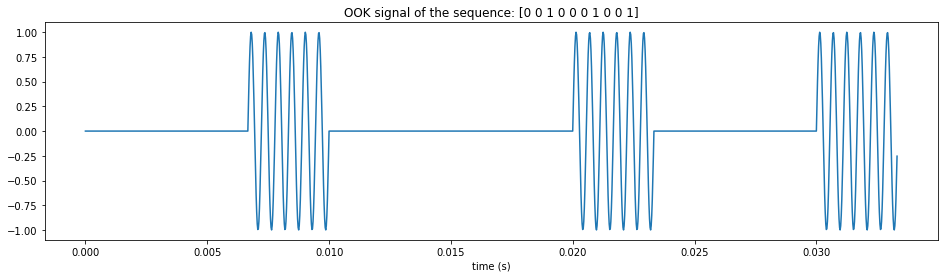

In [ ]:
fig, ax = plt.subplots(figsize = (16,4))
ax.plot(t,OOK)
ax.set_xlabel('time (s)')
ax.set_title(f'OOK signal of the sequence: {np.array2string(bits)}')
plt.show()

The approach of using OOK/ASK as above is not ideal. We can see this by plotting the spectrum

* If one computes the spectrum of the above OOK signal using FFT and plots its the magnitude. We see that the main lobe is wide with lots of ripple which would interfere with signals transmitted on nearby frequencies.
* For instance, the time-bandwidth (TBW) product of a rectangular pulse is 1 (as above), so for a symbol length of 1/300 seconds we get a bandwidth of 300 Hz (The the main lobe full width at half the maximum).


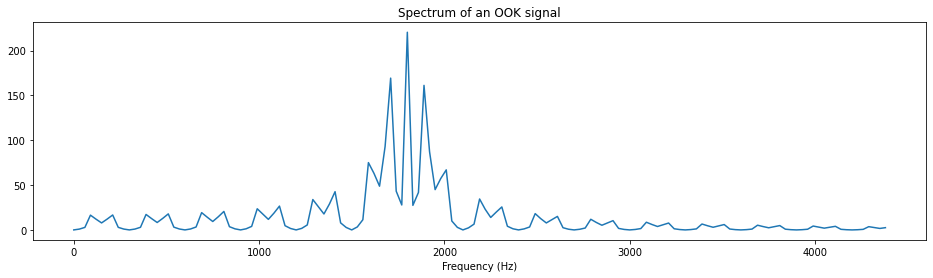

In [ ]:
ook_fft = fft.fft(OOK)
ook_fft_freq = fft.fftfreq(num_samp, 1/sr)

fig, ax = plt.subplots(figsize = (16,4))
ax.plot(ook_fft_freq[:samp_per_symbol], np.abs(ook_fft)[:samp_per_symbol])
ax.set_xlabel('Frequency (Hz)')
ax.set_title('Spectrum of an OOK signal')
plt.show()


Instead of using rectangular pulses, we can use shaped pulses which have more narrowband frequency response. For example, we could use sinc based pulses that would result in bandlimited spectrum. Of course it is not practical to use a sinc, since it is infinite in length. Instead we can use a truncated (windowed) sinc pulses with certain TBW product that would have a finite length as well as narrow bandness. In the communications community the raised cosine and root raised cosine filters are often used. We could use a TBW = 2 pulse (like a hamming window or higher order pulses.

The user can read about filters [here](http://www.commsys.isy.liu.se/TSKS04/lectures/3/MichaelZoltowski_SquareRootRaisedCosine.pdf), but in practice nerds have already developed packages for filter design. For the next example the [`commpy`](https://commpy.readthedocs.io/en/latest/) package is used.

Convolve the sinc with the impulse train to generate a sinc OOK/ASK signal.
modulate the result to 1800Hz
Plot the signal and its spectrum
Comment on the separation between on and off.... what happened? Comment on the spectrum.

* Using the random bit sequence chosen above a new sequence with either zero or discrete impulses spaced fs/baud samples apart is generated. For example a sequence of 1010 would have an impulse at position 0, an impulse at position 294 and zeros elsewhere. Recall that there are 147 samples per symbol for this example.

In [ ]:
# Generate a pulse train where each impulse on symbol (1) is a single pulse
# followed by 146 off samples. A (0) is a train of 147 zeros
pulse_train = np.array([])

for bit in bits:
    pulse = np.zeros(int(samp_per_symbol))
    pulse[0] = bit # set the first value to either a 1 or 0
    # add the 147 samples to the signal
    pulse_train = np.concatenate((pulse_train, pulse))

* The taps for a TBW = 4 RRC filter are generated.

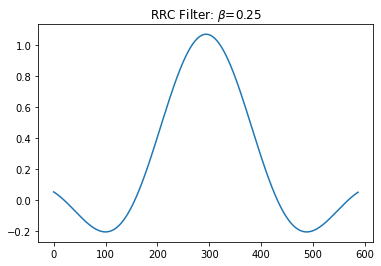

In [ ]:
# Generate root raised cosine filter.

beta=0.25 # rolloff factor
symbol_period = 1/baud
tbw = 4
num_taps = samp_per_symbol*tbw
h = commpy.filters.rrcosfilter(num_taps, beta, symbol_period, sr)

fig, ax = plt.subplots()
ax.plot(h[1])
ax.set_title(r'RRC Filter: $\beta$={}'.format(beta))
plt.show()

* The RRC filter is convolved with the pulse train. In this example `fftconvolve` is used, however, for the length of signals involved `convolve` would also work.
* The convolved signal is then modulated on to the carrier frequency.

In [ ]:
# Convolve pulse train with RRC filter. fftconvolve used instead of convolve.
imp_rrc = signal.fftconvolve(pulse_train,h[1],mode='full')
t=np.arange(len(imp_rrc))/sr
OOK_s = imp_rrc*np.exp(1j*2*np.pi*f0*t)

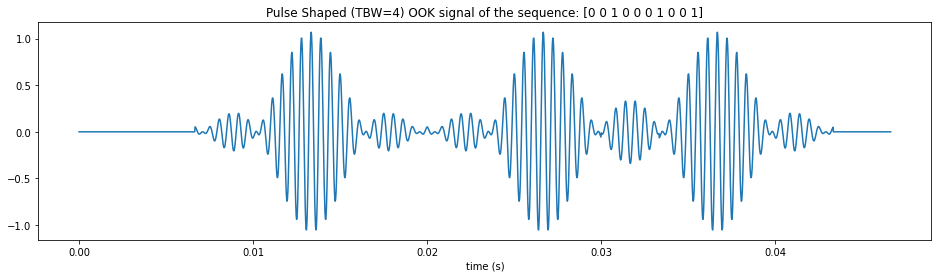

In [ ]:
fig, ax = plt.subplots(figsize = (16,4))
ax.plot(t,np.real(OOK_s))
ax.set_xlabel('time (s)')
ax.set_title(f'Pulse Shaped (TBW={tbw}) OOK signal of the sequence: {np.array2string(bits)}')
plt.show()

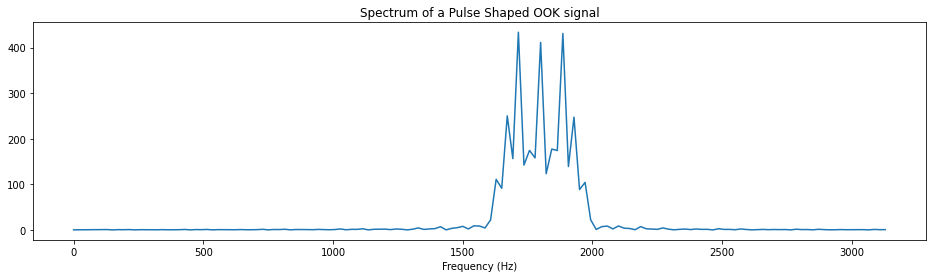

In [ ]:
ook_s_fft = fft.fft(OOK_s)
ook_fft_freq = fft.fftfreq(len(OOK_s), 1/sr)

fig, ax = plt.subplots(figsize = (16,4))
ax.plot(ook_fft_freq[:samp_per_symbol], np.abs(ook_s_fft)[:samp_per_symbol])
ax.set_xlabel('Frequency (Hz)')
ax.set_title('Spectrum of a Pulse Shaped OOK signal')

plt.show()

What we see is that the bandwidth narrows. At the same time, we see leakage between bits in the time series. This is called inter-symbol interference and can cause errors in the detection when there are certain delays that occur between the receiver and the transmitter.

# Phase-shift-keying (PSK)
PSK encodes digital data in the phase of the signal. For example, Binary PSK (BPSK) sends a stream of '0's and '1's by alternating the sign of the carrier in each bit period:  $Real\{πM(t)cos(2\pi f_0t)\}$ , where  M(t)  is a signal of  0 or 1  corresponding to '0's and '1's. The RDS subcarrier in FM radio is BPSK encoded. Also, PSK31 is a very popular text-to-text ham radio protocol for HF that has 31b/s rate, which matches a typical keyboard typing rate. An M-ary symbol can be transmitted by MPSK in which  M(t)  are broken to smaller intervals. For example in 4 PSK (QPSK) 0,1,2,4 are encoded in M(t)={0 or 0.5 or 1 or 1.5} . It could also be encoded in a $45^{\circ}$  rotated constellation  M(t)={0.25 or 0.75 or 1.25 or 1.75}
Here's an example of a BPSK signal using the same bit stream as above:

In [ ]:
# map bits to symbols, a 0 is encoded as -1 and 1 is encoded as 1.
symbols = 2*bits-1
M = np.repeat(symbols, samp_per_symbol)  # generate amplitudes
t = np.arange(num_samp)/sr
BPSK = M*np.sin(2*np.pi*f0*t)

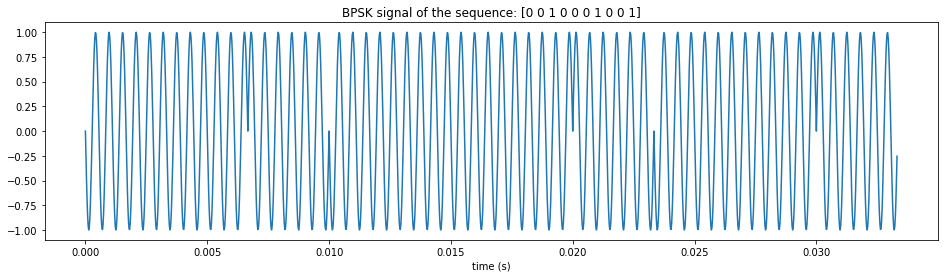

In [ ]:
fig, ax = plt.subplots(figsize = (16,4))
ax.plot(t,BPSK)
ax.set_xlabel('time (s)')
ax.set_title(f'BPSK signal of the sequence: {np.array2string(bits)}')
plt.show()

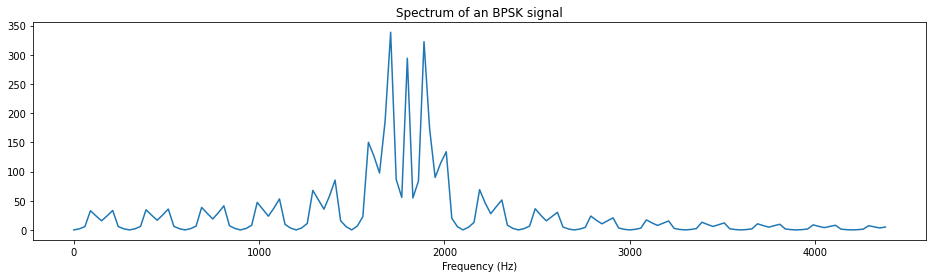

In [ ]:
bpsk_fft = fft.fft(BPSK)
bpsk_fft_freq = fft.fftfreq(num_samp, 1/sr)

fig, ax = plt.subplots(figsize = (16,4))
ax.plot(bpsk_fft_freq[:samp_per_symbol], np.abs(bpsk_fft)[:samp_per_symbol])
ax.set_xlabel('Frequency (Hz)')
ax.set_title('Spectrum of an BPSK signal')
plt.show()

Again, without pulse shaping, the bandwidth of the main lobe is wide and bleeds in to adjacent frequencies.

- We can again generate a pulse train and convolve with a pulse shaping filter
- In this case symbols are 1 and -1 to account for change in phase.

In [ ]:
pulse_train = np.array([])

for symbol in symbols:
    pulse = np.zeros(int(samp_per_symbol))
    pulse[0] = symbol # set the first value to either a 1 or 0
    # add the 147 samples to the signal
    pulse_train = np.concatenate((pulse_train, pulse))

beta=0.25 # rolloff factor
symbol_period = 1/baud
tbw = 4
num_taps = samp_per_symbol*tbw
h = commpy.filters.rrcosfilter(num_taps, beta, symbol_period, sr)

# Convolve pulse train with RRC filter. fftconvolve used instead of convolve.
imp_rrc = signal.fftconvolve(pulse_train,h[1],mode='full')
t=np.arange(len(imp_rrc))/sr
BPSK_s = imp_rrc*np.exp(1j*2*np.pi*f0*t)

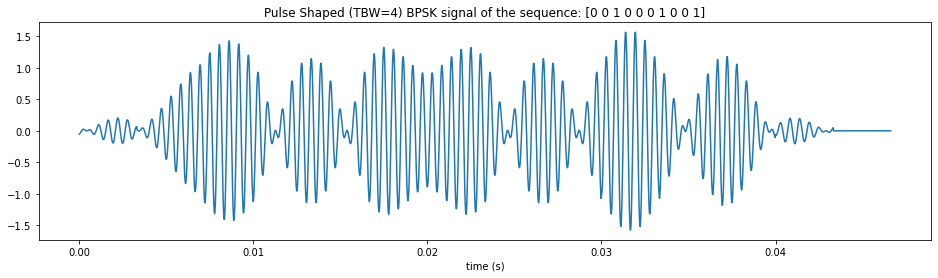

In [ ]:
fig, ax = plt.subplots(figsize = (16,4))
ax.plot(t,np.real(BPSK_s))
ax.set_xlabel('time (s)')
ax.set_title(f'Pulse Shaped (TBW={tbw}) BPSK signal of the sequence: {np.array2string(bits)}')
plt.show()

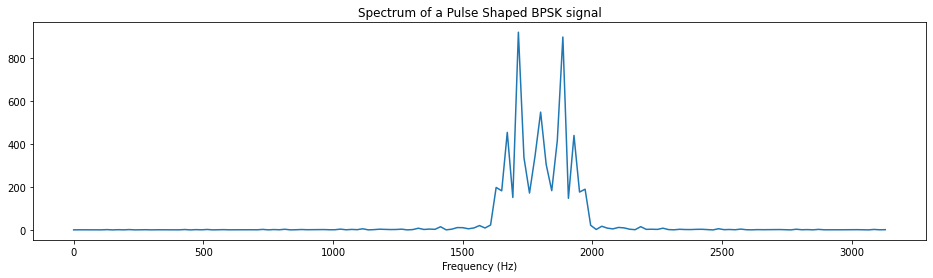

In [ ]:
bpsk_s_fft = fft.fft(BPSK_s)
bpsk_fft_freq = fft.fftfreq(len(BPSK_s), 1/sr)

fig, ax = plt.subplots(figsize = (16,4))
ax.plot(ook_fft_freq[:samp_per_symbol], np.abs(bpsk_s_fft)[:samp_per_symbol])
ax.set_xlabel('Frequency (Hz)')
ax.set_title('Spectrum of a Pulse Shaped BPSK signal')

plt.show()

# Quadrature-Amplitude-Modulation (QAM)
QAM encodes M-arry digital data in both the amplitude and phase, i.e.,  $Real\{M(t)cos(2\pi f_0t)\}$ where M(t) have an amplitude and phase that divides the complex plane into M segments. QAM is heavily used in cable TV and modems. You can see constellations of QAM-16 to QAM-256 which break the complex plane to  4×4 and 16×16 grids.

In [ ]:
sr =  44100 # samples/s
symbol_size = 4 # bits per symbol
baud = 300 # symbol/s, symbol-rate, here 1 bit/symbol 
bit_rate = symbol_size * baud # bits/sec
f0 = 1800 # carrier frequency
num_symbols = 16 # number of symbols
samp_per_symbol = sr//baud # samples/symbol, really this is samples per symbol. 1 bit per symbol here.
num_samp = num_symbols*samp_per_symbol # total samples comprising Nsymbols

In [ ]:
# QAM16 Gray code constellation. Adjacent values differ by 1 bit.
symbol_values = np.random.choice(np.arange(16), num_symbols)
code = np.array((-2-2j, -2-1j,-2+2j,-2+1j,-1-2j,-1-1j,-1+2j,-1+1j,+2-2j,+2-1j,+2+2j,+2+1j,1-2j,+1-1j,1+2j,1+1j))/2
symbols = code[symbol_values]
nibbles = np.array(['{0:04b}'.format(val) for val in symbol_values])

M = np.repeat(symbols, samp_per_symbol)  # generate amplitudes
t = np.arange(num_samp)/sr

QAM = np.real(M.ravel()*np.exp(1j*2*np.pi*f0*t))/np.sqrt(2)/2

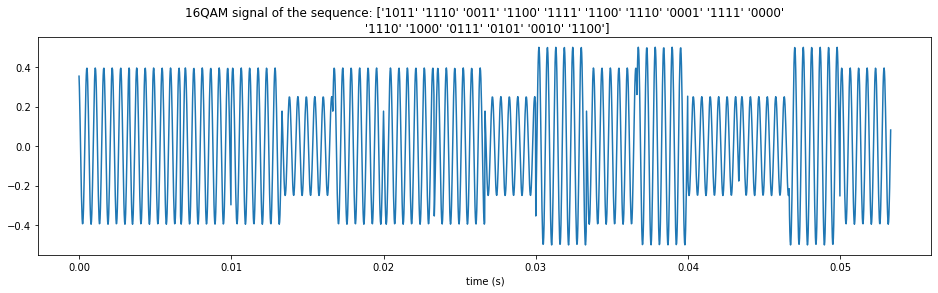

In [ ]:
fig, ax = plt.subplots(figsize = (16,4))
ax.plot(t,QAM)
ax.set_xlabel('time (s)')
ax.set_title(f'16QAM signal of the sequence: {np.array2string(nibbles)}')
plt.show()

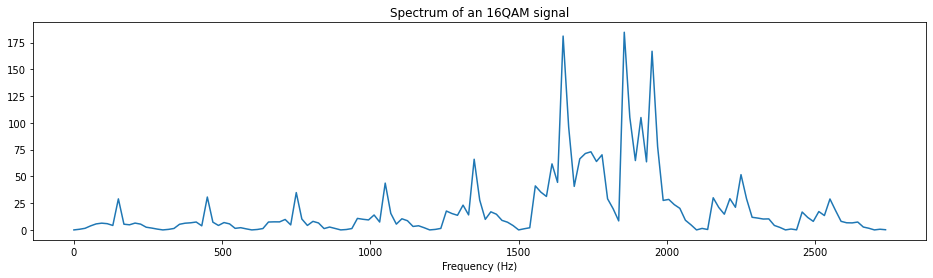

In [ ]:
qam_fft = fft.fft(QAM)
qam_fft_freq = fft.fftfreq(num_samp, 1/sr)

fig, ax = plt.subplots(figsize = (16,4))
ax.plot(qam_fft_freq[:samp_per_symbol], np.abs(qam_fft)[:samp_per_symbol])
ax.set_xlabel('Frequency (Hz)')
ax.set_title('Spectrum of an 16QAM signal')
plt.show()

In [ ]:
pulse_train = np.array([])

for symbol in symbols:
    pulse = np.zeros(int(samp_per_symbol))
    pulse[0] = symbol # set the first value to either a 1 or 0
    # add the 147 samples to the signal
    pulse_train = np.concatenate((pulse_train, pulse))

beta=0.25 # rolloff factor
symbol_period = 1/baud
tbw = 4
num_taps = samp_per_symbol*tbw
h = commpy.filters.rrcosfilter(num_taps, beta, symbol_period, sr)

# Convolve pulse train with RRC filter. fftconvolve used instead of convolve.
imp_rrc = signal.fftconvolve(pulse_train,h[1],mode='full')
t=np.arange(len(imp_rrc))/sr
qam_s = np.real(imp_rrc*np.exp(1j*2*np.pi*f0*t))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


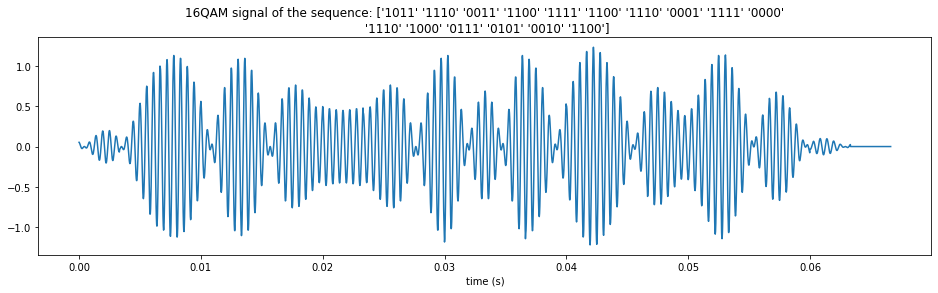

In [ ]:
fig, ax = plt.subplots(figsize = (16,4))
ax.plot(t,qam_s)
ax.set_xlabel('time (s)')
ax.set_title(f'16QAM signal of the sequence: {np.array2string(nibbles)}')
plt.show()

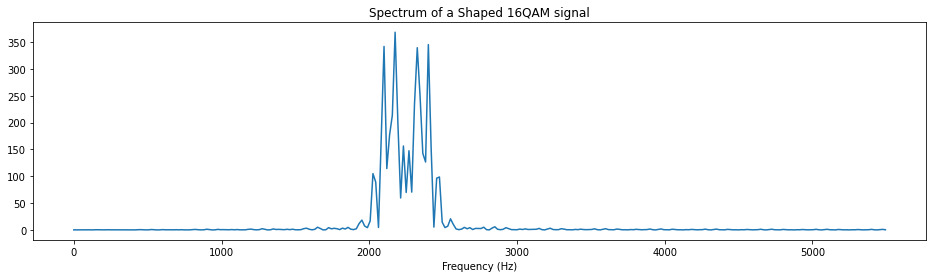

In [ ]:
qam_s_fft = fft.fft(qam_s)
qam_s_fft_freq = fft.fftfreq(num_samp, 1/sr)

fig, ax = plt.subplots(figsize = (16,4))
ax.plot(qam_s_fft_freq[:samp_per_symbol*2], np.abs(qam_s_fft)[:samp_per_symbol*2])
ax.set_xlabel('Frequency (Hz)')
ax.set_title('Spectrum of a Shaped 16QAM signal')
plt.show()

QAM is a very efficient way to use the amplitude as well as the phase to encode M-arry symbols.

The bandwidth is similar to that of a binary sequence, however, bitrate increases, i.e. more information can be encoded using both amplitude and phase within a similar bandwidth.

# Frequency-Shift-Keying (FSK)
FSK encodes digital data in the frequency of the carrier, i.e.,  $cos(2\pi(f_0+M(t)\Delta f)t)$. For binary FSK (BFSK),  M(t)={1 or −1}. In M-arry FSK (MFSK) the frequency band can be broken to more segments. Again, much like PSK, FSK has also a constant envelope which makes it ideal for use with efficient non-linear amplifiers.

The choice of frequencies has a huge impact on our ability to demodulate the signal as well as the bandwidth of it. For example, we would like the frequencies to be orthogonal over a bit period so when detected using correlation we will ge the maximum difference between the results. We would also like the phase to be continuous for the sidelobes to decay rapidly and not interfere with nearby channels.

For example, the choice of frequencies of 1200 Hz and 2400 Hz below for a bitrate of 300 baud results in 4 and 8 cycles per bit period respectively. The outcome is a smooth phase and orthogonal frequencies.

In [ ]:
sr =  44100 # samples/s
symbol_size = 1 # bit per symbol, 1 for OOK
baud = 300 # symbol/s, symbol-rate, here 1 bit/symbol 
bit_rate = symbol_size * baud # bits/sec
f0 = 1800 # carrier frequency
num_bits = 10 # number of bits
samp_per_symbol = sr//baud # samples/symbol, really this is samples per symbol. 1 bit per symbol here.
num_samp = num_bits*samp_per_symbol # total samples comprising Nbits
bits = np.random.choice([0,1], num_bits)

In [ ]:
# map bits to symbols, a 0 is encoded as -1 and 1 is encoded as 1.
symbols = 2*bits-1
M = np.repeat(symbols, samp_per_symbol)  # generate amplitudes
delta = 600 # frequency shift
t = np.arange(num_samp)/sr
assert M.shape==t.shape

# compute phase by integrating frequency
# Note: frequency is the deriviative  of phase wrt time.
# i.e. a change in phase divided by change in time is frequency
# hence we integrate phase to get the frequency at every time step
ph = 2*np.pi*np.cumsum(f0 + M*delta)/sr
FSK = np.sin(ph)

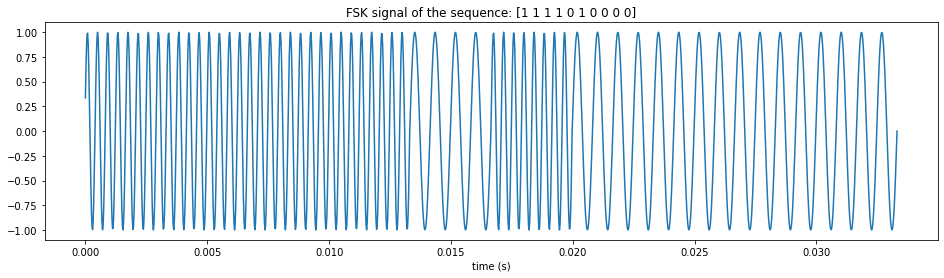

In [ ]:
fig, ax = plt.subplots(figsize = (16,4))
ax.plot(t,FSK)
ax.set_xlabel('time (s)')
ax.set_title(f'FSK signal of the sequence: {np.array2string(bits)}')
plt.show()

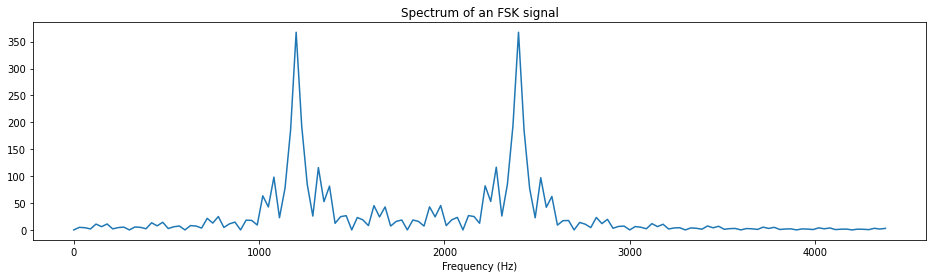

In [ ]:
fsk_fft = fft.fft(FSK)
fsk_fft_freq = fft.fftfreq(num_samp, 1/sr)

fig, ax = plt.subplots(figsize = (16,4))
ax.plot(fsk_fft_freq[:samp_per_symbol], np.abs(fsk_fft)[:samp_per_symbol])
ax.set_xlabel('Frequency (Hz)')
ax.set_title('Spectrum of an FSK signal')
plt.show()

In [ ]:
pulse_train = np.array([])

for symbol in symbols:
    pulse = np.zeros(int(samp_per_symbol))
    pulse[0] = symbol # set the first value to either a 1 or -1
    # add the 147 samples to the signal
    pulse_train = np.concatenate((pulse_train, pulse))

beta=0.25 # rolloff factor
symbol_period = 1/baud
tbw = 4
num_taps = samp_per_symbol*tbw
h = commpy.filters.rrcosfilter(num_taps, beta, symbol_period, sr)

# Convolve pulse train with RRC filter. fftconvolve used instead of convolve.
imp_rrc = signal.fftconvolve(pulse_train,h[1],mode='full')
ph = 2*np.pi*np.cumsum(f0+imp_rrc*delta)/sr
t=np.arange(len(imp_rrc))/sr
fsk_s = np.exp(1j*ph)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


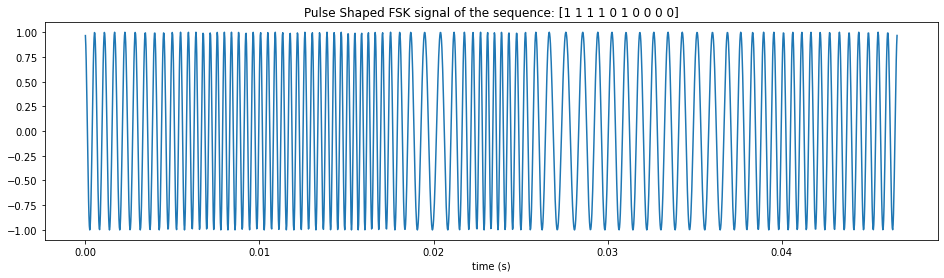

In [ ]:
fig, ax = plt.subplots(figsize = (16,4))
ax.plot(t,fsk_s)
ax.set_xlabel('time (s)')
ax.set_title(f'Pulse Shaped FSK signal of the sequence: {np.array2string(bits)}')
plt.show()

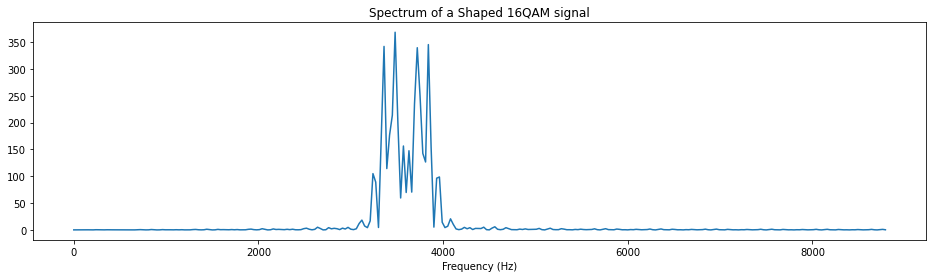

In [ ]:
fsk_s_fft = fft.fft(fsk_s)
fsk_s_fft_freq = fft.fftfreq(num_samp, 1/sr)

fig, ax = plt.subplots(figsize = (16,4))
ax.plot(fsk_s_fft_freq[:samp_per_symbol*2], np.abs(qam_s_fft)[:samp_per_symbol*2])
ax.set_xlabel('Frequency (Hz)')
ax.set_title('Spectrum of a Shaped 16QAM signal')
plt.show()